In [40]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd

In [46]:
dataset = ""#sklearn"
if "sklearn" in dataset:
    breast_cancer = load_breast_cancer()
    df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
    df["benign"] = breast_cancer.target
else:
    df = pd.read_csv('breast_cancer.csv', delimiter=',' , header=0,encoding='latin-1')
    X = df.loc[:, df.columns != "Class"]
    y = df.loc[:, df.columns == "Class"]
    y = binary_labels = y.map(lambda x: 1 if x == 'recurrence-events' else 0)

In [35]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [50]:
if "sklearn" in dataset:
    majority_df = df[df["benign"] == 1]
    minority_df = df[df["benign"] == 0]
    minority_downsampled_df = resample(minority_df, replace=True, n_samples=30, random_state=42)
    downsampled_df = pd.concat([majority_df, minority_downsampled_df])
    downsampled_df["benign"].value_counts()
    y = downsampled_df["benign"]
    X = downsampled_df.drop("benign", axis=1)
else:
    
    # Encode categorical variables
    le = LabelEncoder()
    X = X.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [54]:
model = IsolationForest(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[y_pred == -1] = 0
confusion_matrix(y_test, y_pred)

array([[18, 32],
       [17,  5]], dtype=int64)

## PCA Plot Generation

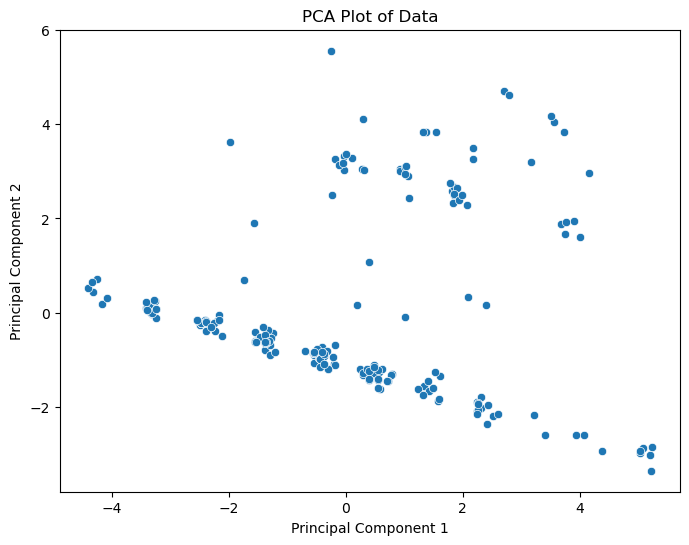

In [57]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)

components = pca.fit_transform(X_train)

# Create a DataFrame with the reduced dimensions
components_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Component 1', y='Component 2', data=components_df)
plt.title('PCA Plot of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Local Outlier Factor Technique
We use the LocalOutlierFactor technique to find outliers

In [95]:
from sklearn.neighbors import LocalOutlierFactor 
import numpy as np

lof = LocalOutlierFactor(n_neighbors=15) 
lof.fit(X_train)

# Calculate the outlier scores for each point 
lof_scores = lof.negative_outlier_factor_ 

# Identify the points with the highest outlier scores 
lof_outliers = np.argwhere(lof_scores > np.percentile(lof_scores, 85)) 


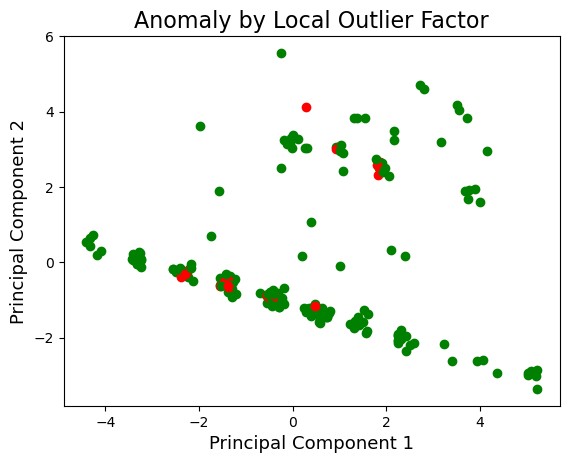

In [91]:
# Plot anomly 
colors=['green','red'] 

for i in range(len(X_train)): 
    if i not in lof_outliers: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[0]) # Not anomly 
    else: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[1]) # anomly 
plt.xlabel('Principal Component 1',fontsize=13) 
plt.ylabel('Principal Component 2',fontsize=13)         
plt.title('Anomaly by Local Outlier Factor',fontsize=16)         
plt.show() 

## Isolation Forest Technique
We test and compare with the Isolation Forest technique the outliers found

In [98]:
from sklearn.ensemble import IsolationForest 

model = IsolationForest(n_estimators=2000, max_samples='auto', contamination=0.175, random_state=42)#contamination=0.05) 
model.fit(X_train) 
model.fit(components_df)
  
# Calculate the outlier scores for each point 
#ir_scores = model.decision_function(X_train)
ir_scores = model.decision_function(components_df) 
  
# Identify the points with the highest outlier scores 
ir_outliers = np.argwhere(ir_scores < np.percentile(ir_scores, 17))


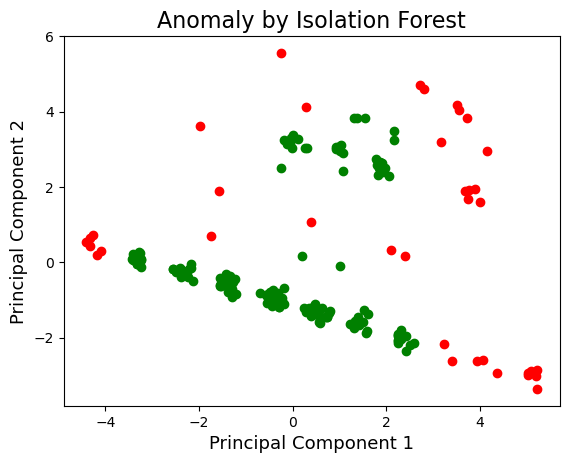

In [99]:
# Plot anomly 
colors=['green','red'] 

for i in range(len(X_train)):
    if i not in ir_outliers:
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[0]) # Not anomly 
    else: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[1]) # anomly 
plt.xlabel('Principal Component 1',fontsize=13) 
plt.ylabel('Principal Component 2',fontsize=13)         
plt.title('Anomaly by Isolation Forest',fontsize=16)         
plt.show()

## One-class Support Vector Machines (SVMs)

In [87]:
from sklearn import svm 

model = svm.OneClassSVM(nu=0.05) 
model.fit(X_train) 
  
# Calculate the outlier scores for each point 
svm_scores = model.decision_function(X) 
  
# Identify the points with the highest outlier scores 
svm_outliers = np.argwhere(svm_scores < np.percentile(svm_scores, 15)) 


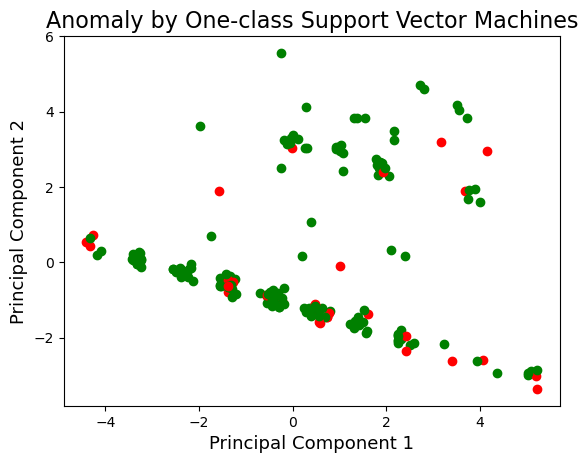

In [88]:
# Plot anomly 
colors=['green','red'] 

for i in range(len(X_train)): 
    if i not in svm_outliers: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[0]) # Not anomly 
    else: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[1]) # anomly 
plt.xlabel('Principal Component 1',fontsize=13) 
plt.ylabel('Principal Component 2',fontsize=13)         
plt.title('Anomaly by One-class Support Vector Machines',fontsize=16)         
plt.show() 

In [94]:
common_outliers = np.intersect1d(svm_outliers, ir_outliers)
out = [x for x in lof_outliers if x in ir_outliers or x in svm_outliers]
print(out)
out = [x for x in ir_outliers if x in lof_outliers or x in svm_outliers]
print(out)
out = [x for x in svm_outliers if x in ir_outliers or x in lof_outliers]
print(out)
#print(ir_outliers, ir_outliers.shape)
#print(lof_outliers, lof_outliers.shape)
#print(svm_outliers, svm_outliers.shape)
print(common_outliers)
print(len(X_train))

[array([60], dtype=int64), array([136], dtype=int64), array([151], dtype=int64), array([205], dtype=int64)]
[array([37], dtype=int64), array([53], dtype=int64), array([59], dtype=int64), array([150], dtype=int64)]
[array([37], dtype=int64), array([53], dtype=int64), array([59], dtype=int64), array([60], dtype=int64), array([136], dtype=int64), array([150], dtype=int64), array([151], dtype=int64), array([205], dtype=int64)]
[ 37  53  59 150]
214
